<a href="https://colab.research.google.com/github/DSwing/Transformer/blob/main/Eng_Ita_translation_with_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Sequence-to-Sequence Transformer for English-to-Italian Translation from Scratch

**Date created:** 2024/10/13<br>
**Description:** Implementing a sequence-to-sequence Transformer and training it for the English-to-Italian translation task.

Hello, everyone!

Here we'll build a basic Transformer model using Tensorflow and Keras and use it to build a translator from English to Italian.

Transformer, introduced by Vaswani et al. in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762), is a deep learning architecture designed for sequence-to-sequence tasks, such as machine translation and text summarization. It is based on self-attention mechanisms and has become the foundation for many state-of-the-art natural language processing models, like GPT and BERT.  

We'll be working with an English-to-Italian translation dataset provided by [Anki](https://www.manythings.org/anki/). The notebook follows the following steps:
* Import libraries
* Load dataset
* Exploratory data anlysis
* Preprocess the text using the kerasNLP subword tokenization
* Create the dataset tensors
* Build the model
* Train and compare for different hyperparameters
* Train the best model
* Evaluate the results
* Test the translations

Despite the choice to build a lightweight model for learning purposes, the quality of the resulting translations is impressive, and the model can be easily expanded to achieve even better results.

The following works have greatly inspired the development of this notebook:  
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
* [English-to-Spanish translation with a sequence-to-sequence Transformer](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)
* [English-to-Spanish translation with KerasHub](https://keras.io/examples/nlp/neural_machine_translation_with_keras_hub/)  
* [Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer)
* [Trasformer From Scratch for Text Summarization](https://www.kaggle.com/code/zalcode/trasformer-from-scratch-for-text-summarization)

## Loading libraries

In [43]:
!pip install -q --upgrade rouge-score
!pip install -q --upgrade keras-nlp

In [44]:
import os
import random
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import keras_nlp
from collections import Counter
import pickle
import ipywidgets as widgets
from IPython.display import display, clear_output

## Importing data  
I downloaded the dataset from [Anki](https://www.manythings.org/anki/) and put it on my google drive.

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls /content/drive/MyDrive/ita-eng/

ita-eng.zip


In [ ]:
!unzip /content/drive/MyDrive/ita-eng/ita-eng.zip -d /content/drive/MyDrive/ita-eng/

Archive:  /content/drive/MyDrive/ita-eng/ita-eng.zip
  inflating: /content/drive/MyDrive/ita-eng/ita.txt  
  inflating: /content/drive/MyDrive/ita-eng/_about.txt  


## Exploring the dataset

In [46]:
text_file = "/content/drive/MyDrive/ita-eng/ita.txt"

In [47]:
with open(text_file) as f:
    for i in range(10):
        print(f.readline())

Hi.	Ciao!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)

Hi.	Ciao.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4522287 (Guybrush88)

Run!	Corri!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)

Run!	Corra!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)

Run!	Correte!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906350 (Guybrush88)

Who?	Chi?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #2126402 (Guybrush88)

Wow!	Wow!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #1922050 (Guybrush88)

Duck!	Amore!	CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #5502518 (Guybrush88)

Duck!	Tesoro!	CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #5502519 (Guybrush88)

Duck!	Immergiti!	CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #5502520 (Guybrush88)



The data are structured in a tab-separated CSV with three columns. The first column contains the original sentence, the second contains the translation, and the third is for attribution. We can drop the third column and format the data as paired (English, Italian) sentences, stored in a text_pairs list.

In [48]:
text_pairs = []
with open(text_file) as f:
    for line in f:
        sline = line.split("\t")
        if len(sline) == 3:
            eng, ita, _ = sline
            eng, ita = eng.strip(), ita.strip()
            eng, ita = eng.lower(), ita.lower()
            text_pairs.append((eng, ita))
for _ in range(5):
    print(random.choice(text_pairs))

("don't you like tom?", 'non vi piace tom?')
("it's important to have courage.", 'è importante avere coraggio.')
('here is the money you wanted.', 'ecco i soldi che volevi.')
("why didn't you want to go to boston?", 'perché non ha voluto andare a boston?')
("i thought i'd been stabbed.", 'pensavo di essere stato pugnalato.')


We analyse the distribution of the lenghts of the sentences in the two languages.

In [49]:
eng_len = []
ita_len = []
for eng, ita in text_pairs:
    eng_len.append(len(eng.split()))
    ita_len.append(len(ita.split()))
df_len = pd.DataFrame(dict(eng_len = eng_len, ita_len = ita_len))
df_len.head()

,eng_len,ita_len
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


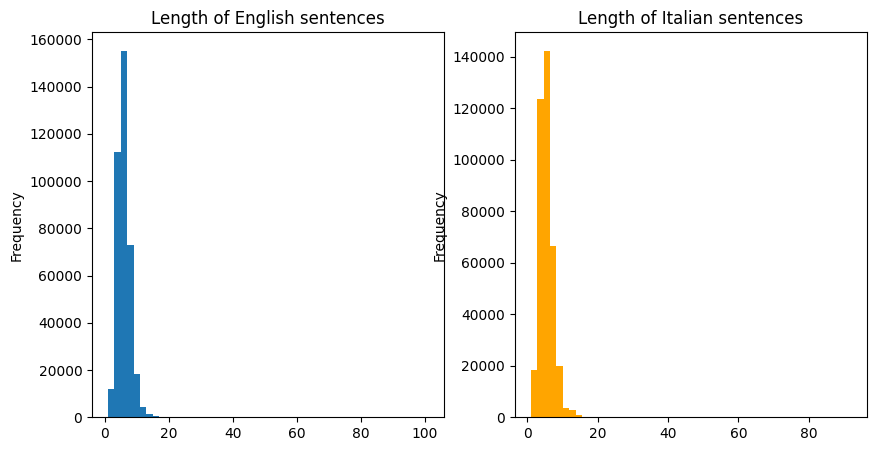

In [50]:
df_len.describe()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df_len['eng_len'].plot(kind='hist', bins=50, ax=ax[0], title='Length of English sentences')
df_len['ita_len'].plot(kind='hist', bins=50, ax=ax[1], title='Length of Italian sentences', color='orange')
plt.show()

Since the majority of sentences in the dataset are under 10 words in both languages, we will exclude sentences longer than 10 words. This approach helps reduce the negative effects of padding excessively long sequences, which would otherwise result in many pad tokens. A large number of pad tokens can dilute meaningful data and limit the model's ability to learn effectively.

In [51]:
text_pairs = [x for x in text_pairs if len(x[0].split()) < 11 and len(x[1].split()) < 11]

We randomly separate a training set from a validation set.

In [52]:
random.shuffle(text_pairs)

num_val_samples = int(0.2 * len(text_pairs))

val_pairs = text_pairs[:num_val_samples]
train_pairs = text_pairs[num_val_samples:]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")

367478 total pairs
293983 training pairs
73495 validation pairs



Not all words appear with the same frequency in sentences; some occur very rarely. Removing these infrequently used words can improve the model's learning by reducing noise and focusing on more common, meaningful patterns in the data.

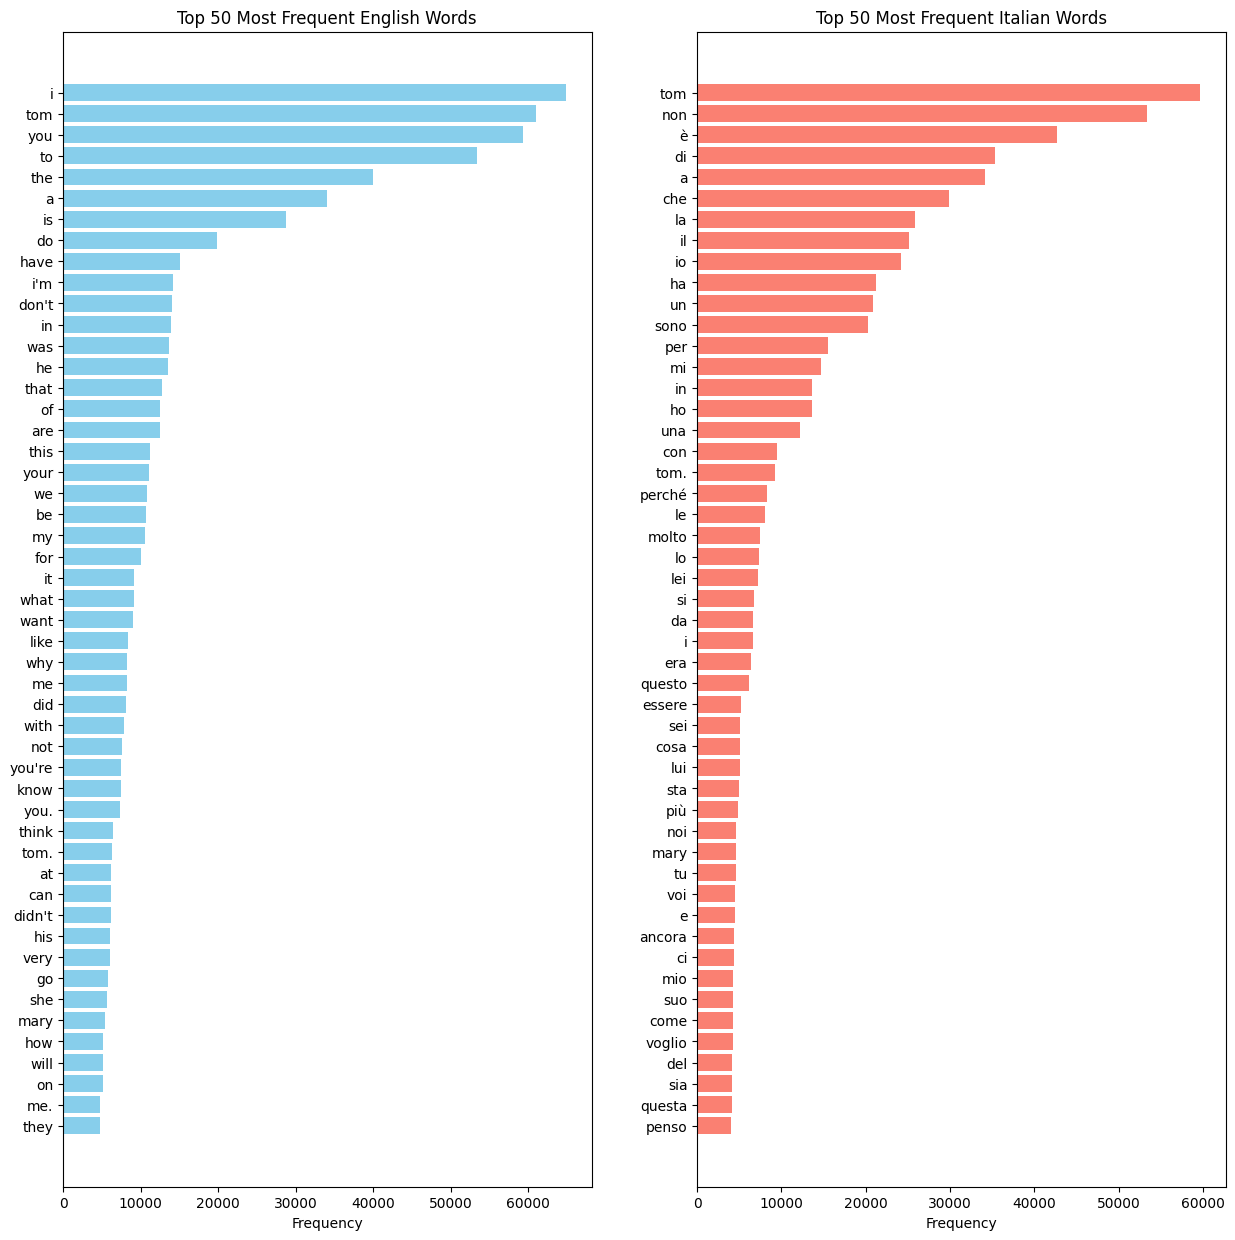

In [53]:
eng_words = ' '.join([x[0] for x in train_pairs]).split()
ita_words = ' '.join([x[1] for x in train_pairs]).split()

eng_count = Counter(eng_words)
ita_count = Counter(ita_words)

top_eng_words = eng_count.most_common(50)
top_ita_words = ita_count.most_common(50)

# Separate words and counts for plotting
eng_words, eng_freqs = zip(*top_eng_words)
ita_words, ita_freqs = zip(*top_ita_words)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 15))

# Plot for English words
axes[0].barh(eng_words, eng_freqs, color='skyblue')
axes[0].set_title('Top 50 Most Frequent English Words')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()  # To show the most frequent word on top

# Plot for Italian words
axes[1].barh(ita_words, ita_freqs, color='salmon')
axes[1].set_title('Top 50 Most Frequent Italian Words')
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

In [54]:
len_eng = sum(eng_count.values())
eng_perc= 0
vocab_eng95 = 0
for i, x in enumerate(eng_count):
    eng_perc += eng_count[x]/len_eng
    vocab_eng95 = i
    if eng_perc>0.95:
        break
print(f'Total number of words in English sentences: {len(eng_count)}')
print(f'Number of words that form 95% of total word occurrences in English sentences: {vocab_eng95}')

len_ita = sum(ita_count.values())
ita_perc= 0
vocab_ita95 = 0
for i, x in enumerate(ita_count):
    ita_perc += ita_count[x]/len_ita
    vocab_ita95 = i
    if ita_perc>0.95:
        break
print(f'Total number of words in Italian sentences: {len(ita_count)}')
print(f'Number of words that form 95% of total word occurrences in Italian sentences: {vocab_ita95}')


Total number of words in English sentences: 23664
Number of words that form 95% of total word occurrences in English sentences: 7036
Total number of words in Italian sentences: 43696
Number of words that form 95% of total word occurrences in Italian sentences: 16197


Out of the 23,664 unique English words in the dataset, only 7,036 account for 95% of the total word occurrences. To simplify the model's learning process and reduce its complexity, we will restrict the English vocabulary to these 7,036 most frequent words. Similarly, we will limit the Italian vocabulary to 16,197 words, which cover 95% of word occurrences in the Italian sentences.

It's worth noting that the Italian vocabulary results significantly larger than the English one. This difference arises due to the greater number of word inflections in Italian, as verbs, nouns, and adjectives change form depending on tense, gender, and plurality.

## Tokenization
We'll define two tokenizers—one for the source language (English) and another for the target language (Italian). For this, we'll use keras_nlp.tokenizers.WordPieceTokenizer, which is designed to tokenize text into subword units based on a WordPiece vocabulary. This tokenizer provides functions for both tokenizing raw text and detokenizing sequences of tokens back into words.

The WordPiece tokenization algorithm is a subword-based approach that strikes a balance between traditional word tokenizers and character tokenizers. Word tokenizers require very large vocabularies to cover a wide range of words, while character tokenizers break down text into individual characters, which don't convey the same semantic meaning as words. By using subword tokenization, we achieve a compromise: it allows the model to handle rare or unseen words by splitting them into meaningful subunits, while still capturing the linguistic structure of more common words."

In [55]:
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

eng_samples = [text_pair[0] for text_pair in train_pairs]
eng_vocab = train_word_piece(eng_samples, vocab_size=vocab_eng95, reserved_tokens=reserved_tokens)

ita_samples = [text_pair[1] for text_pair in train_pairs]
ita_vocab = train_word_piece(ita_samples, vocab_size=vocab_ita95, reserved_tokens=reserved_tokens)

eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=False, special_tokens_in_strings=True, special_tokens=reserved_tokens
)
ita_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=ita_vocab, lowercase=False, special_tokens_in_strings = True, special_tokens=reserved_tokens
)

In [56]:
eng_token_vocab = eng_tokenizer.vocabulary_size()
ita_token_vocab = ita_tokenizer.vocabulary_size()
print(f'Total number of subword token in English tokenizer: {eng_token_vocab}')
print(f'Total number of subword token in Italian tokenizer: {ita_token_vocab}')

Total number of subword token in English tokenizer: 5792
Total number of subword token in Italian tokenizer: 8901


We can observe that subword tokenization results in a reduced number of tokens compared to a word-level tokenizer. This is particularly true for the Italian vocabulary, as Italian words undergo numerous inflections, making subword tokenization more efficient in capturing the linguistic variations.

In [57]:
eng_lengths = [eng_tokenizer(x[0]).shape[0] for x in train_pairs[:1000]]
ita_lengths = [ita_tokenizer(x[1]).shape[0] for x in train_pairs[:1000]]
eng_len = int(np.percentile(eng_lengths, 95))
ita_len = int(np.percentile(ita_lengths, 95))
print(f'95th percentile of number of subword-tokens in English sentences: {eng_len}')
print(f'95th percentile of number of subword-tokens in Italian sentences: {ita_len}')

95th percentile of number of subword-tokens in English sentences: 11
95th percentile of number of subword-tokens in Italian sentences: 11


To improve the model's learning efficiency, we limit the sentence length to the 95th percentile of token counts in the dataset. This helps reduce the number of padding tokens, which are added to make all sequences the same length. Excessive padding can dilute meaningful information in the data, making it harder for the model to learn. By capping sentence length at the 95th percentile, we minimize padding while retaining most of the relevant content, allowing the model to focus on learning the key patterns in the sequences.

## Preprocessing text
In the following code cells, we define two functions, preprocess_ita and preprocess_eng, that are responsible for preparing the Italian and English text data for input into our model. This preprocessing is crucial to ensure that the text is formatted consistently and that the model can effectively learn from it.

In [60]:
def preprocess_ita(train, sequence_length = ita_len):
    def preprocess_text(text):
        batch_size = tf.shape(text)[0]
        ita = ita_tokenizer(text)
        ita_start_end_packer = keras_nlp.layers.StartEndPacker(
            sequence_length=sequence_length + 1,
            start_value=ita_tokenizer.token_to_id("[START]"),
            end_value=ita_tokenizer.token_to_id("[END]"),
            pad_value=ita_tokenizer.token_to_id("[PAD]"),
        )
        ita = ita_start_end_packer(ita)
        if train:
            return ita[:,:-1]
        else:
            return ita[:,1:]
    return preprocess_text

def preprocess_eng(text, sequence_length = eng_len):
    batch_size = tf.shape(text)[0]
    eng = eng_tokenizer(text)
    eng_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=sequence_length,
        pad_value=eng_tokenizer.token_to_id("[PAD]"),
    )
    eng = eng_start_end_packer(eng)
    return eng

In [61]:
def make_ita_ds(ita_texts, train):
    ita_ds = tf.data.Dataset.from_tensor_slices(ita_texts)
    ita_ds = ita_ds.batch(batch_size=64)
    ita_ds = ita_ds.map(preprocess_ita(train=train), num_parallel_calls=tf.data.AUTOTUNE)
    return ita_ds

def make_eng_ds(eng_texts):
    eng_ds = tf.data.Dataset.from_tensor_slices(eng_texts)
    eng_ds = eng_ds.batch(batch_size=64)
    eng_ds = eng_ds.map(preprocess_eng, num_parallel_calls=tf.data.AUTOTUNE)
    return eng_ds

def make_dataset(pairs):
    eng_texts, ita_texts = zip(*pairs)
    ita_ds = make_ita_ds(list(ita_texts) ,train=True)
    ita_target_ds = make_ita_ds(list(ita_texts), train=False)
    eng_ds = make_eng_ds(list(eng_texts))

    ds = tf.data.Dataset.zip((eng_ds, ita_ds))
    ds = tf.data.Dataset.zip(ds, ita_target_ds)
    ds = ds.shuffle(2048).prefetch(16).cache()
    return ds

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

The train_ds and val_ds tensors have the same nested structure:

In [27]:
train_ds.element_spec

((TensorSpec(shape=(None, 11), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 11), dtype=tf.int32, name=None)),
 TensorSpec(shape=(None, 11), dtype=tf.int32, name=None))

The tensor has two main parts: Input and Target.  

The Input part consists of two tensors:
One for English sentences
One for Italian sentences

The Target part is a single tensor containing Italian sentences

The key difference between the Italian sentences in the Input and those in the Target lies in how they're processed: Input Italian sentences are one token shifted. This means they're offset by one position.

In [28]:
for inputs, targets in train_ds.take(1):
    print(f'inputs[0].shape: {inputs[0].shape}')
    print(f'inputs[1].shape: {inputs[1].shape}')
    print(f"targets.shape: {targets.shape}")

inputs[0].shape: (64, 11)
inputs[1].shape: (64, 11)
targets.shape: (64, 11)


In [29]:
for inputs, targets in train_ds.take(1):
  print(inputs[0][0])
  print(inputs[1][0])
  print(targets[0])

tf.Tensor([  35  260    9   46   80 4003 1940  321   84   45 3438], shape=(11,), dtype=int32)
tf.Tensor([   2   74   69   79   44  343 4755 3801   73  106   27], shape=(11,), dtype=int32)
tf.Tensor([  74   69   79   44  343 4755 3801   73  106   27    3], shape=(11,), dtype=int32)


In [30]:
for inputs, targets in train_ds.take(1):
  print(eng_tokenizer.detokenize(inputs[0][0]))
  print(ita_tokenizer.detokenize(inputs[1][0]))
  print(ita_tokenizer.detokenize(targets[0]))

go and get me some milk . [PAD] [PAD] [PAD] [PAD]
[START] vammi a prendere del latte ! [END] [PAD] [PAD]
vammi a prendere del latte ! [END] [PAD] [PAD] [PAD]


# Generate the model

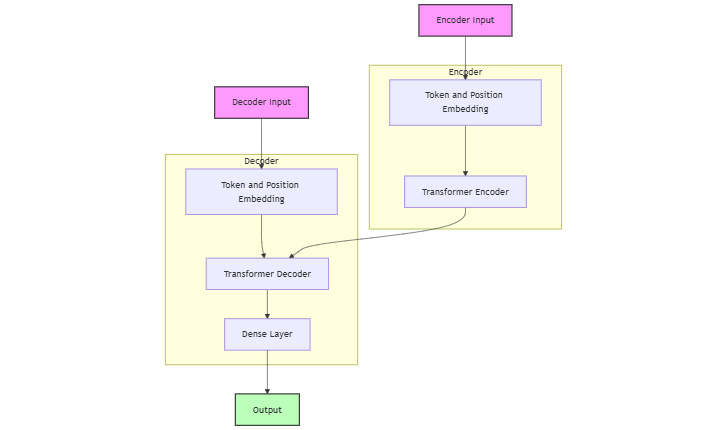


The code below defines a function create_transformer that constructs a Transformer model with customizable parameters.  

The function creates an encoder-decoder structure, where the encoder processes the input sequence (English sentences), and the decoder generates the output sequence (Italian translations). The model utilizes token and position embeddings, along with multi-head attention mechanisms, to capture complex relationships in the input and generate appropriate outputs.

The model is parametrized to let us measure performaces using different parameters:
* Vocabulary sizes for both input and output languages
* Embedding dimensions  
* Intermediate dimensions in the Transformer layers  
* Number of attention heads.

This architecture enables the model to effectively learn complex relationships between input and output sequences, making it suitable for various sequence-to-sequence tasks.


In [24]:
def create_transformer(perc_vocab_size, embedding_dim, intermediate_dim, num_heads):
    encoder_inputs = keras.Input(shape=(None,), name="encoder_inputs")
    decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")

    #encoder

    y = keras_nlp.layers.TokenAndPositionEmbedding(
                 vocabulary_size=int(perc_vocab_size*eng_token_vocab),
                 sequence_length=eng_len,
                 embedding_dim=embedding_dim,
                 )(encoder_inputs)

    y = keras_nlp.layers.TransformerEncoder(
                 intermediate_dim=intermediate_dim,
                 num_heads=num_heads
                 )(y)

    #decoder

    x = keras_nlp.layers.TokenAndPositionEmbedding(
                 vocabulary_size=int(perc_vocab_size*ita_token_vocab),
                 sequence_length=ita_len,
                 embedding_dim=embedding_dim,
                 )(decoder_inputs)

    xy = keras_nlp.layers.TransformerDecoder(
                 intermediate_dim=intermediate_dim,
                 num_heads=num_heads
                 )(x, y)

    xy = keras.layers.Dense(ita_token_vocab
                 )(xy)


    transformer = keras.Model(
        [encoder_inputs, decoder_inputs],
        xy,
        name="transformer",
        )
    return transformer

In this code cell, we are setting up a grid search for hyperparameter tuning to evaluate different configurations of the transformer model. Hyperparameter tuning is a crucial step in optimizing machine learning models, as it helps identify the best combination of parameters that can enhance model performance.

In [25]:
import itertools
perc_vocab_sizes = [0.9,1.0]
embedding_dims=[128, 64]
intermediate_dims=[128,64]
num_heads=[4,8]
hyperparameter_grid = list(itertools.product(perc_vocab_sizes, embedding_dims, intermediate_dims, num_heads))

transformers = []
for perc_vocab_size, embedding_dim, intermediate_dim, num_heads in hyperparameter_grid:
    transformers.append(create_transformer(perc_vocab_size, embedding_dim, intermediate_dim, num_heads))

In [73]:
transformers[0].summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │        668,416 │ encoder_inputs[0][0]   │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │      1,025,664 │ decoder_inputs[0][0]   │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_109   │ (None, None, 128)      │         99,584 │ token_and_position_em… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_109   │ (None, None, 128)      │        165,888 │ token_and_position_em… │
│ (TransformerDecoder)      │                        │                │ transformer_encoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_109 (Dense)         │ (None, None, 8892)     │      1,147,068 │ transformer_decoder_1… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,106,620 (11.85 MB)

 Trainable params: 3,106,620 (11.85 MB)

 Non-trainable params: 0 (0.00 B)

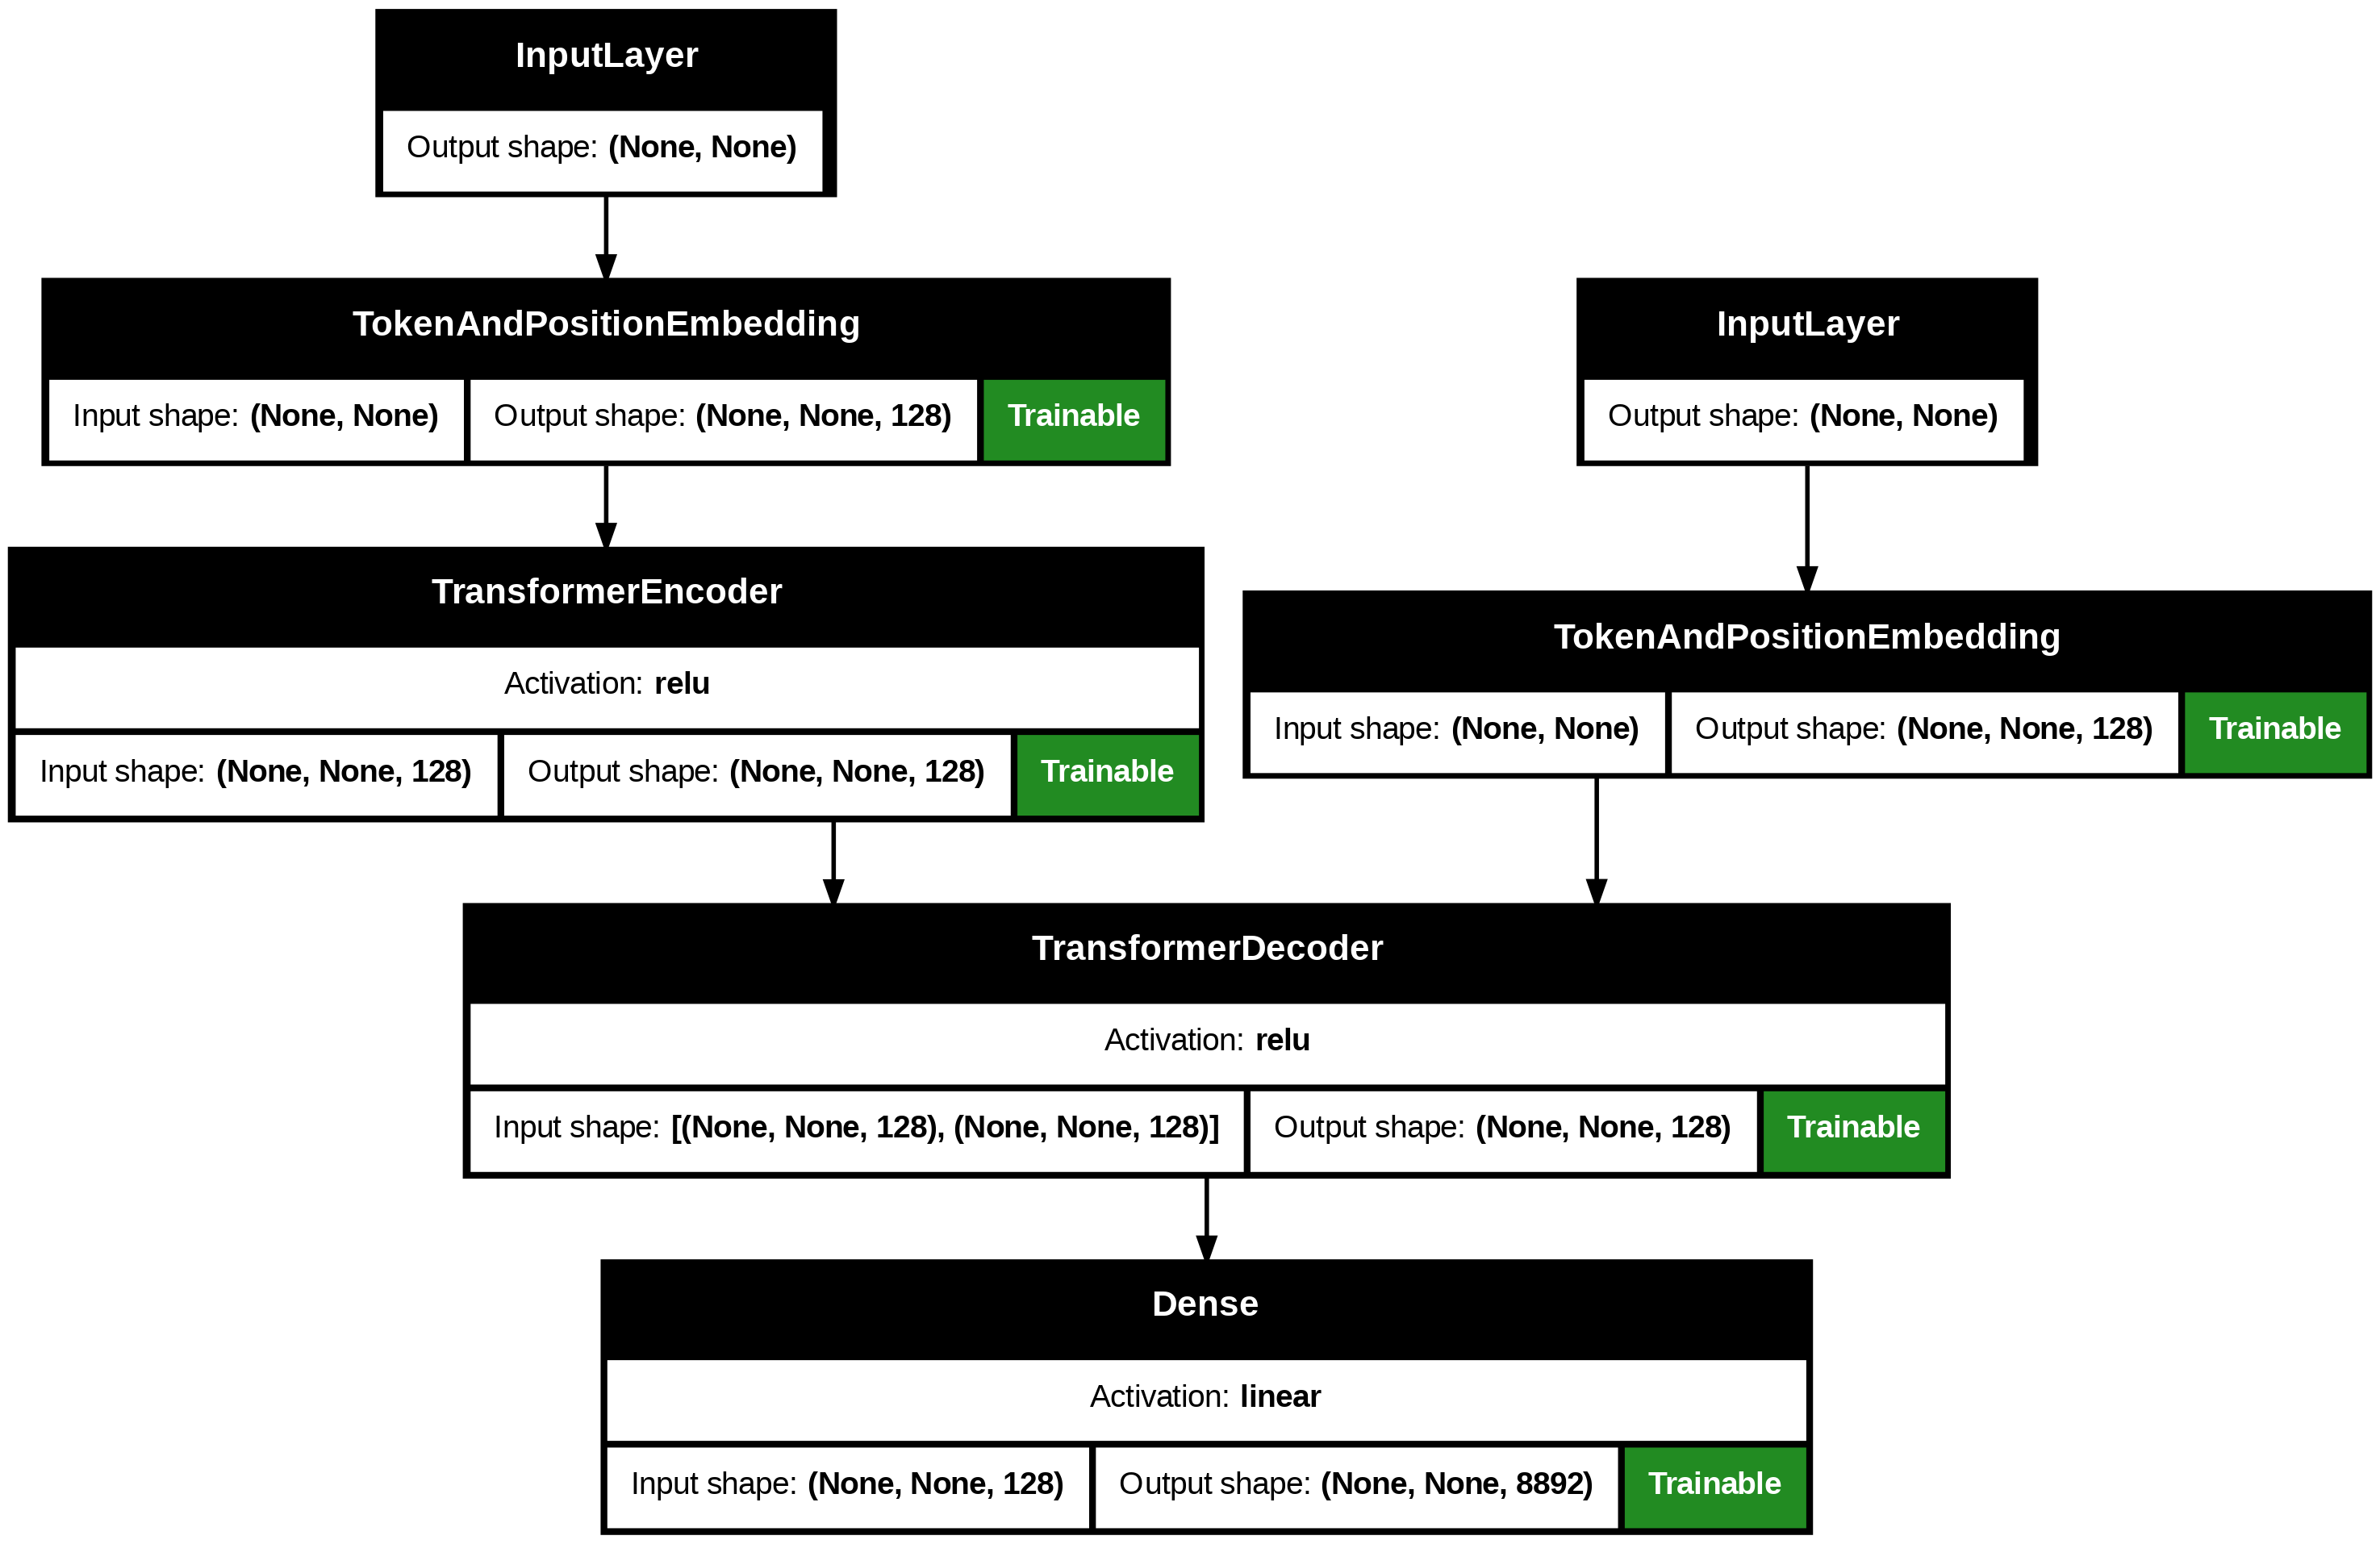

In [74]:
plot_model(transformers[0], show_shapes=True, show_trainable=True, show_layer_activations=True)

## Training

We training the transformer models that were created in the previous step. The objective is to evaluate their performance by fitting each model on the training dataset and recording the training history for analysis.

In [76]:
epochs = 5

hist_df = pd.DataFrame()
for i, transformer in enumerate(transformers):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
    transformer.compile(optimizer,
                        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy']
                        )
    history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)
    df = pd.DataFrame(history.history)
    df['model'] = i
    hist_df = pd.concat([hist_df, df])

Epoch 1/5
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 74s 11ms/step - accuracy: 0.5431 - loss: 3.7435 - val_accuracy: 0.7324 - val_loss: 1.5436
Epoch 2/5
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.7590 - loss: 1.3426 - val_accuracy: 0.7914 - val_loss: 1.0360
Epoch 3/5
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.8075 - loss: 0.9227 - val_accuracy: 0.8142 - val_loss: 0.8337
Epoch 4/5
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.8299 - loss: 0.7331 - val_accuracy: 0.8271 - val_loss: 0.7290
Epoch 5/5
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.8441 - loss: 0.6258 - val_accuracy: 0.8355 - val_loss: 0.6679
Epoch 1/5
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - accuracy: 0.5348 - loss: 3.7566 - val_accuracy: 0.7279 - val_loss: 1.5690
Epoch 2/5
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.7557 - loss: 1.3659 - val_accuracy: 0.7901 - val_loss: 1.0491
Epoch 3/5
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.8069 - loss: 0.9341 

## Compare the models

In [83]:
hist_df.head()

,accuracy,loss,val_accuracy,val_loss,model
0,0.635033,2.523242,0.732367,1.543599,0
1,0.774853,1.206963,0.791410,1.036009,0
2,0.814023,0.866427,0.814242,0.833683,0
3,0.833764,0.702813,0.827054,0.729024,0
4,0.846721,0.607251,0.835477,0.667901,0


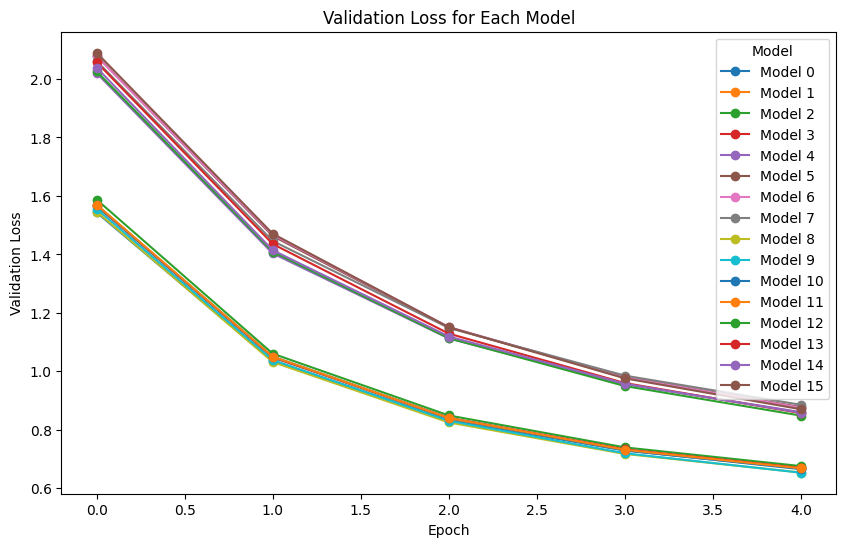

In [92]:
plt.figure(figsize=(10, 6))
for model_id in hist_df['model'].unique():
    model_data = hist_df[hist_df['model'] == model_id]
    plt.plot(model_data.index, model_data['val_loss'], label=f'Model {model_id}', marker='o')

# Add labels and title
plt.title('Validation Loss for Each Model')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(title='Model')
plt.show()

The nineth model is the best performer:

In [95]:
hist_df.iloc[np.argmin(hist_df['val_loss'])]

,4
accuracy,0.849359
loss,0.592313
val_accuracy,0.838970
val_loss,0.653392
model,9.000000


In [26]:
hyperparameter_grid[9]

(1.0, 128, 128, 8)

## Generate the model using the best parameters and train it for a longer period  

We define the model to be trained, compile it, and initiate the training process.
We allso implement strategies to manage potential overfitting through early stopping.

In [64]:
epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

transformer = create_transformer(*hyperparameter_grid[9])
hist_df = pd.DataFrame()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
transformer.compile(optimizer,
                        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy']
                        )
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])
transformer.save('/content/drive/MyDrive/ita-eng/transformer.keras')

Epoch 1/30
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 70s 11ms/step - accuracy: 0.5385 - loss: 3.7312 - val_accuracy: 0.7331 - val_loss: 1.5547
Epoch 2/30
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - accuracy: 0.7565 - loss: 1.3576 - val_accuracy: 0.7952 - val_loss: 1.0286
Epoch 3/30
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.8080 - loss: 0.9229 - val_accuracy: 0.8193 - val_loss: 0.8175
Epoch 4/30
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.8317 - loss: 0.7257 - val_accuracy: 0.8321 - val_loss: 0.7093
Epoch 5/30
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.8467 - loss: 0.6141 - val_accuracy: 0.8403 - val_loss: 0.6457
Epoch 6/30
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.8573 - loss: 0.5429 - val_accuracy: 0.8461 - val_loss: 0.6053
Epoch 7/30
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.8654 - loss: 0.4928 - val_accuracy: 0.8502 - val_loss: 0.5784
Epoch 8/30
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.8718 - loss: 

## Test the translator

We define a function decode_sequences that takes input sentences in English, translates them into Italian using the trained transformer model, and returns the generated Italian sentences.

In [65]:
def decode_sequences(input_sentences):
    batch_size = 1

    # Tokenize the encoder input.
    encoder_input_tokens = tf.convert_to_tensor(eng_tokenizer(input_sentences))
    token_length = tf.shape(encoder_input_tokens)[1]

    # Apply padding if necessary
    if token_length < eng_len:
        pads = tf.fill((1, eng_len - token_length), 0)
        encoder_input_tokens = tf.concat([encoder_input_tokens, pads], axis=1)
    elif token_length > eng_len:
        encoder_input_tokens = encoder_input_tokens[:,:eng_len]
    # Define a function that outputs the next token's probability given the input sequence.
    def next(prompt, cache, index):
        logits = transformer.predict([encoder_input_tokens, prompt], verbose=0)[:, index-1, :]
        # Ignore hidden states for now; only needed for contrastive search.
        hidden_states = None
        return logits, hidden_states, cache

    # Build a prompt of length 40 with a start token and padding tokens.
    length = ita_len
    start = tf.fill((batch_size, 1), ita_tokenizer.token_to_id("[START]"))
    pad = tf.fill((batch_size, length - 1), ita_tokenizer.token_to_id("[PAD]"))
    prompt = tf.concat([start, pad], axis=-1)

    # Generate tokens using GreedySampler
    generated_tokens = keras_nlp.samplers.GreedySampler()(
        next,
        prompt,
        stop_token_ids=[ita_tokenizer.token_to_id("[END]")],
        index=1,  # Start sampling after start token.
    )
    generated_sentences = ita_tokenizer.detokenize(generated_tokens)
    translated = generated_sentences[0]
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    return translated

In [66]:
#Testing with example sentences
test_eng_texts = [pair[0] for pair in val_pairs]
for i in range(5):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequences([input_sentence])
    print(f"** Example {i} **")
    print(input_sentence)
    print(translated)
    print()


** Example 0 **
have you read it?
l ' hai letto ?

** Example 1 **
put the rope in the box.
metti la corda nella scatola .

** Example 2 **
i bumped into him at the station.
mi sono imbattuto in lui alla stazione .

** Example 3 **
i never give up.
non mi arrendendo mai .

** Example 4 **
do you think we're going to be rescued?
pensate che verremo salvati ?



We initialize and compute the ROUGE metrics applied to a subset of translations to evaluate the quality of the translations produced by our transformer model. ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a popular metric used for assessing the quality of summaries and translations by comparing them to reference sentences.

In [67]:
# Initialize ROUGE metrics
rouge_1 = keras_nlp.metrics.RougeN(order=1)
rouge_2 = keras_nlp.metrics.RougeN(order=2)


# Measure ROUGE scores and accuracy on test dataset

for test_pair in val_pairs[:1000]:  # Assuming test_pairs contains (input_sentence, reference_sentence) tuples
    input_sentence = test_pair[0]
    reference_sentence = test_pair[1]

    # Decode the input sentence to get the translated sentence
    translated_sentence = decode_sequences([input_sentence])

    # Update ROUGE metrics
    rouge_1(reference_sentence, translated_sentence)
    rouge_2(reference_sentence, translated_sentence)

# Print results
print("ROUGE-1 Score: ", rouge_1.result())
print("ROUGE-2 Score: ", rouge_2.result())


ROUGE-1 Score:  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.72309405>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.7092451>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.7112204>}
ROUGE-2 Score:  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.5361225>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.5280786>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.52768475>}


In [68]:
rouge_1 = {x: y.numpy() for x,y in zip(rouge_1.result(),rouge_1.result().values())}
rouge_2 = {x: y.numpy() for x,y in zip(rouge_2.result(),rouge_2.result().values())}
rouge_1['Score method'] = 'Rouge-1'
rouge_2['Score method'] = 'Rouge-2'
rouge_df = pd.DataFrame([rouge_1, rouge_2])
rouge_df

,precision,recall,f1_score,Score method
0,0.723094,0.709245,0.711220,Rouge-1
1,0.536123,0.528079,0.527685,Rouge-2


ROUGE-1 Score interpretation:

Precision indicates that about 72.31% of the words generated by the model are also found in the reference translations. This suggests a strong alignment between the model's outputs and the expected translations.
Recall reflects that around 70.92% of the words in the reference translations were successfully captured by the model. This indicates that the model might be missing some important words present in the reference sentences, though the overlap is still significant.
F1 Score is the harmonic mean of precision and recall, standing at approximately 71.12%. This score serves as a balance between precision and recall, highlighting that the model maintains a good trade-off between accurately capturing words and avoiding extraneous words.  

ROUGE-2 Score interpretation:

Precision for ROUGE-2 indicates that about 53.61% of the bigrams (two-word sequences) produced by the model match those in the reference translations. This suggests that while the model performs well at the unigram level, it has room for improvement in capturing phrases or combinations of words.
Recall shows that the model successfully captured approximately 52.81% of the bigrams present in the reference translations. This indicates a moderate ability to replicate meaningful phrases from the reference text, but again, there are gaps in capturing all relevant information.
F1 Score at around 52.76% suggests a similar trend as precision and recall, highlighting the balance between these metrics but indicating that the model's performance on capturing larger, context-rich sequences is less robust compared to individual words.

## Conclusions  

Despite the model's relatively small size, it has yielded remarkable results in translation tasks, as evidenced by the metrics presented above. This achievement highlights a key principle in machine learning: that a well-optimized, less complex model can sometimes outperform more complex counterparts when trained on the right dataset and tuned effectively. The performance of our model demonstrates its ability to capture the essential features of the language pair (English and Italian) it was trained on, allowing it to generate coherent and contextually relevant translations.  

Through the comparison of different model configurations, we have gleaned valuable insights regarding the relationship between model complexity and performance. The results indicate that more complex models consistently outperform their simpler counterparts. This observation suggests that increasing the number of parameters and enhancing the architecture can lead to improved learning outcomes.  

One specific area where complexity can be beneficial is in the attention mechanism, particularly through the increase in the number of heads in the attention layers. Multi-head attention allows the model to focus on different parts of the input sequence simultaneously, which is crucial for understanding context. By expanding the number of heads, the model gains the capacity to capture diverse contextual relationships within the data, leading to richer and more nuanced translations.  

Incorporating additional complexity, such as deeper layers or more attention heads, could provide the model with a better understanding of language structure and semantics. This, in turn, may enhance its ability to produce more accurate and contextually appropriate translations, particularly in longer and more intricate sentences where understanding relationships between words becomes increasingly important.  



## Let's translate
Here a simple widget to test the model yourself.

In [69]:


# Create a text input widget
text_input = widgets.Text(
    description='English:',
    placeholder='Type something here...',
    layout=widgets.Layout(width='600px')  # Optional: set the width
)

submit_button = widgets.Button(description='Translate')

# Function to handle button click
def on_submit(b):
    clear_output(wait=True)
    display(hbox)
    print(f"Italian: {decode_sequences([text_input.value.lower()])}")

# Attach the function to the button
submit_button.on_click(on_submit)

hbox = widgets.HBox([text_input, submit_button])
display(hbox)

Italian: quanti anni ha .
